<a href="https://colab.research.google.com/github/NaomiKikuchi/ds-em-producao/blob/main/notebooks/m07_v03_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0. IMPORTS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install inflection

In [3]:
pip install boruta

     |████████████████████████████████| 56 kB 4.6 MB/s 


In [4]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec
import xgboost as xgb


from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate
from scipy import stats as ss

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()
jupyter_settings()

def ml_error(model_name, y, yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rmse = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({'Model Name': model_name,
                       'MAE': mae,
                       'MAPE': mape,
                       'RMSE': rmse}, index=[0])
  
def cross_validation(x_training, kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1, kfold+1)):
    if verbose:
      print(f'\nKfold number: {k}.')
    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    # training
    xtraining = training.drop(columns=['date', 'sales'])
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop(columns=['date', 'sales'])
    yvalidation = validation['sales']

    # model
    m = model.fit(xtraining, ytraining)

    # prediction
    yhat = m.predict( xvalidation )

    # performace
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
    
    # store performace of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + " +/- " + np.round(np.std(mae_list), 2).astype(str),
                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + " +/- " + np.round(np.std(mape_list), 2).astype(str),
                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + " +/- " + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [6]:
def cramer_v(x,y):
    cm = pd.crosstab( x, y ).values
    
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading data

In [7]:
df_sales_raw = pd.read_csv('/content/drive/MyDrive/Data Scientist/ds-em-producao/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/MyDrive/Data Scientist/ds-em-producao/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore( x )

cols_new = list(map(snake_case, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [10]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [11]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 2.5. Fillout NA

In [13]:
df1['competition_distance'].max()

75860.0

In [14]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month 
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)
#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)
#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
  
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes =df1.select_dtypes(exclude=  ['int64', 'float64', 'datetime64[ns]'])

In [18]:
# Central tendency: mean, median

# Dispersion: std, min, max range, skew, kurtosis

### 1.7.1 Numerical Attributes

In [19]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion: std, min, max range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T


# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1114.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,6.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,199980.00,5935.44,2330.00,12547.65,10.24,147.79
8,competition_open_since_month,1.00,12.00,11.00,6.79,7.00,3.31,-0.04,-1.23
9,competition_open_since_year,1900.00,2015.00,115.00,2010.32,2012.00,5.52,-7.24,124.07


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


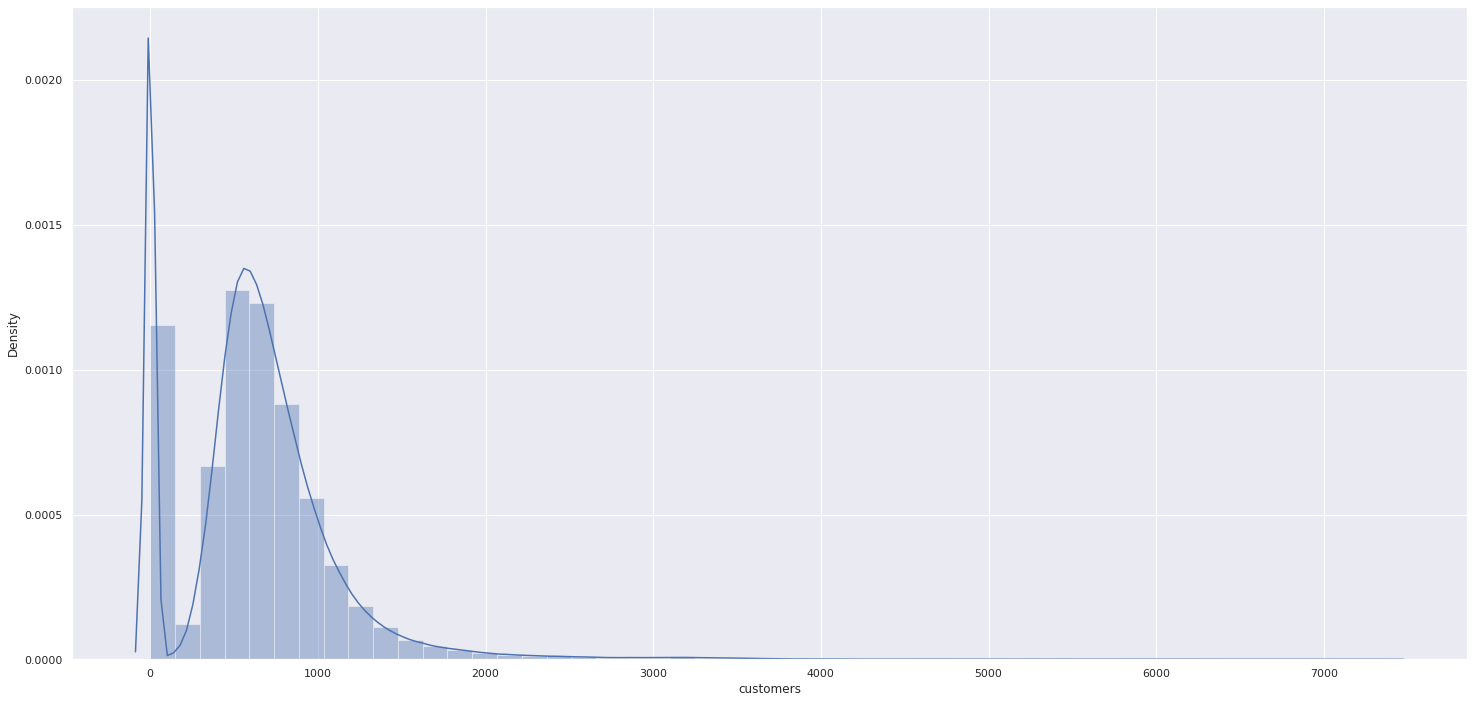

In [21]:
sns.distplot(df1['customers'])

### 1.7.2 - Categorical Attributes

In [22]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

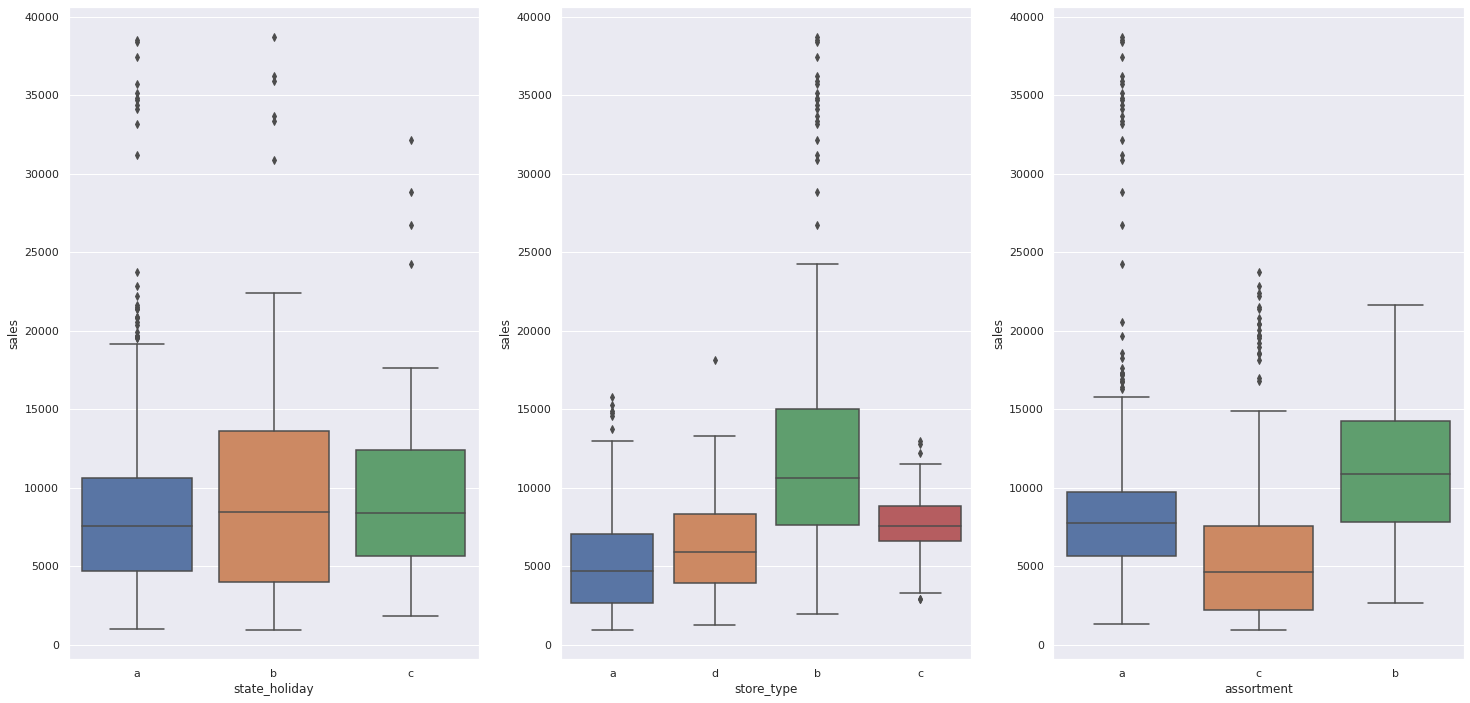

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]


plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0. FEATURE ENGENEERING

In [24]:
df2 = df1.copy()

## 2.1. Mindmap Hypothesis

In [25]:
Image( "../img/MindMapHypothesis.png")

## 2.2. Criação de Hipoteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

###  2.2.3. Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engeeniring

In [26]:
df2 = df1.copy()

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month = x['competition_open_since_month'], 
                                                                 day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', "%Y-%W-%w" ) - 
                                              datetime.timedelta( days=7 ))

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x == 'b' else 'extended')


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                           else 'easter_holiday' if x == 'b' 
                           else 'christmas' if x == 'c' 
                           else 'regular_day')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  del sys.path[0]


# 3.0. - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das Colunas

In [29]:
# customers: dado indisponível no momento da previsão

df3 = df3.drop(columns=['customers', 'open', 'promo_interval', 'month_map'], axis=1)

# 4.0. - ANÁLISE EXPLORATÓRIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

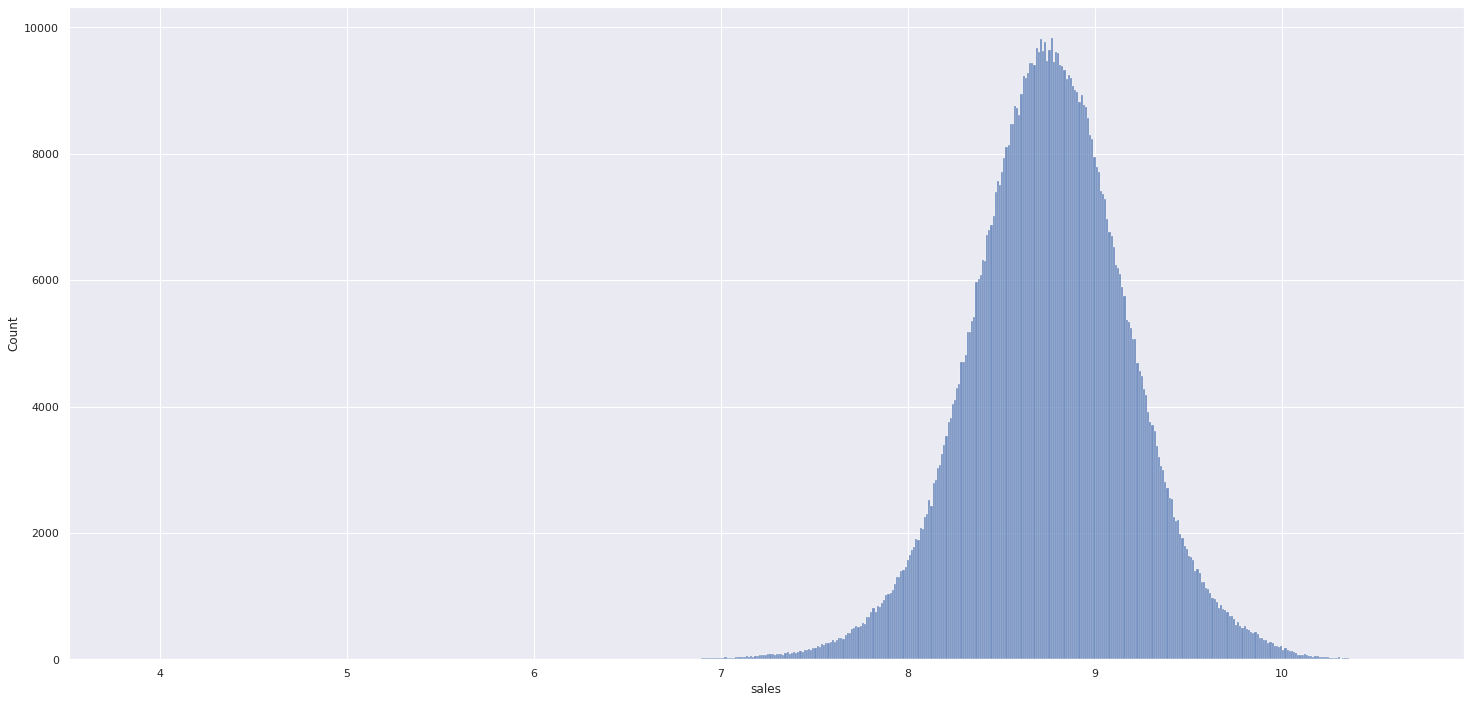

In [31]:
sns.histplot(np.log1p(df4['sales']))

### 4.1.2. Numerical Variable

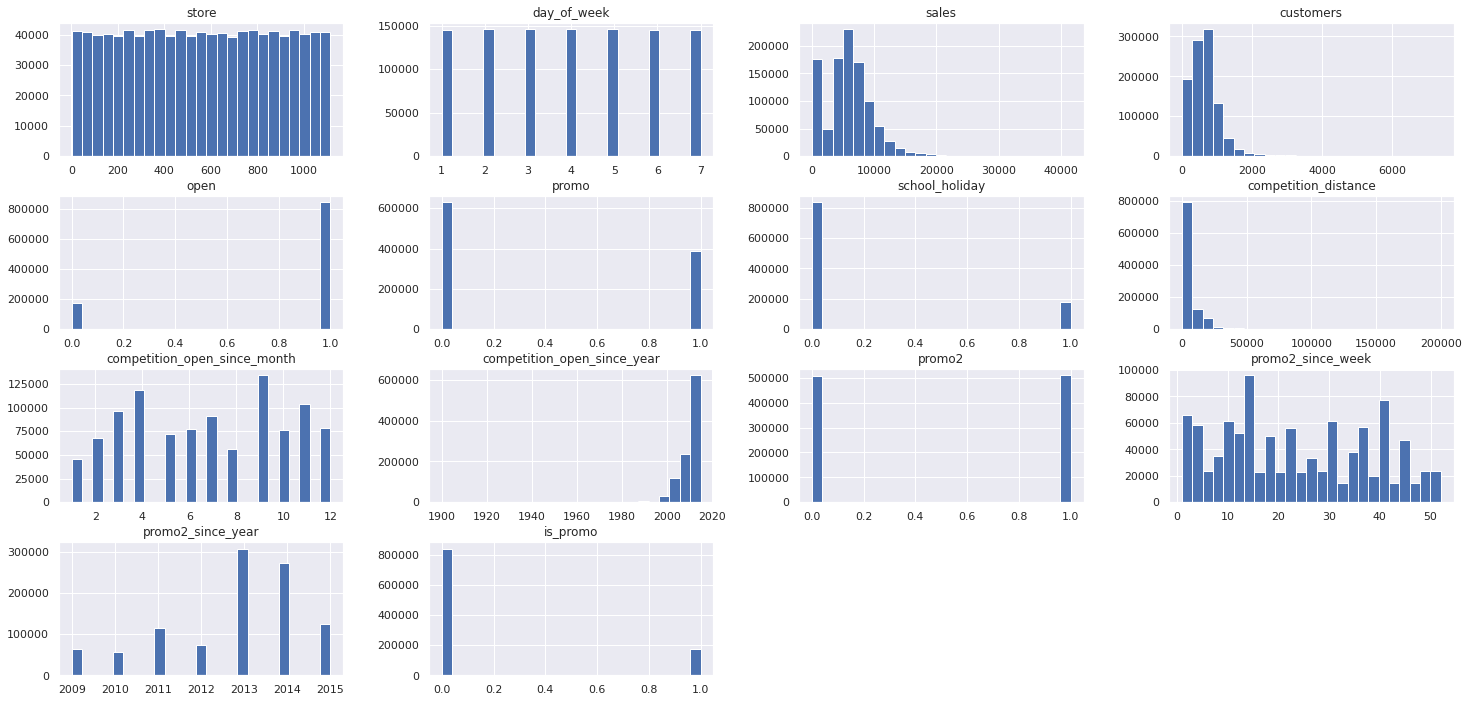

In [32]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [34]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


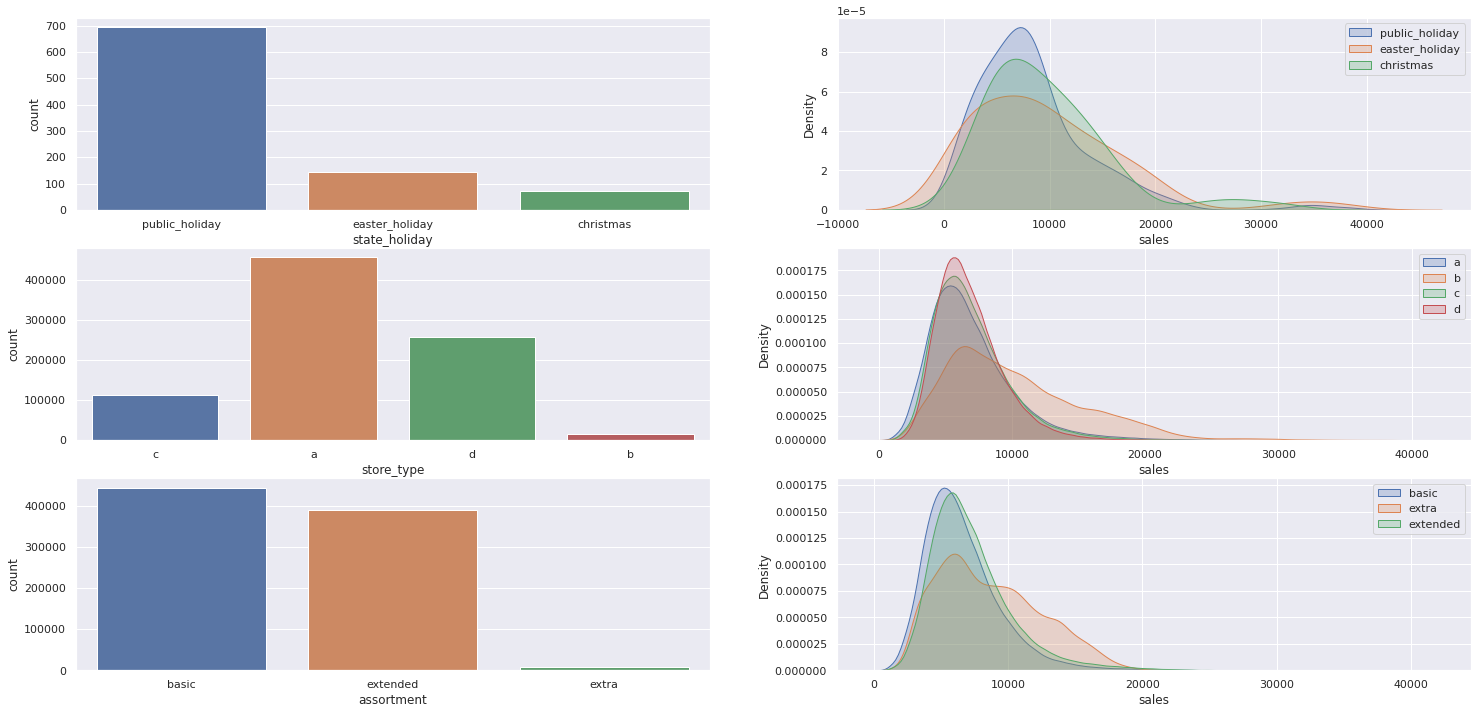

In [35]:
# state holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3, 2, 1)
sns.countplot(a['state_holiday']);
plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )
plt.legend()

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df3['store_type']);
plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )
plt.legend()

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df3['assortment']);
plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
plt.legend()

## 4.2. Análise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais.
**R:**

Volume absoluto: **falso**

Volume médio por loja: **verdadeiro**

O volume de vendas por loja por dia é maior nas lojas do tipo 'extra', porém o número de lojas com esse tipo de sortimento é menor.

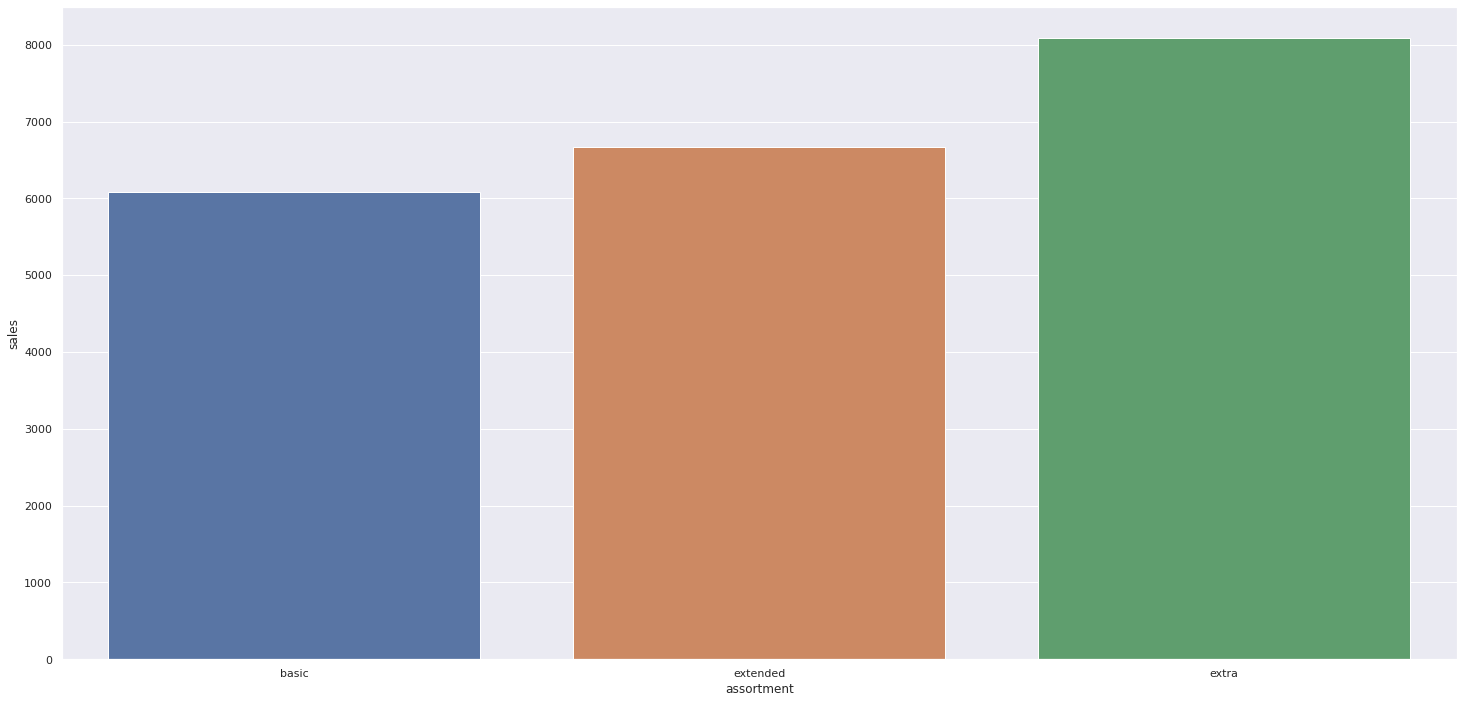

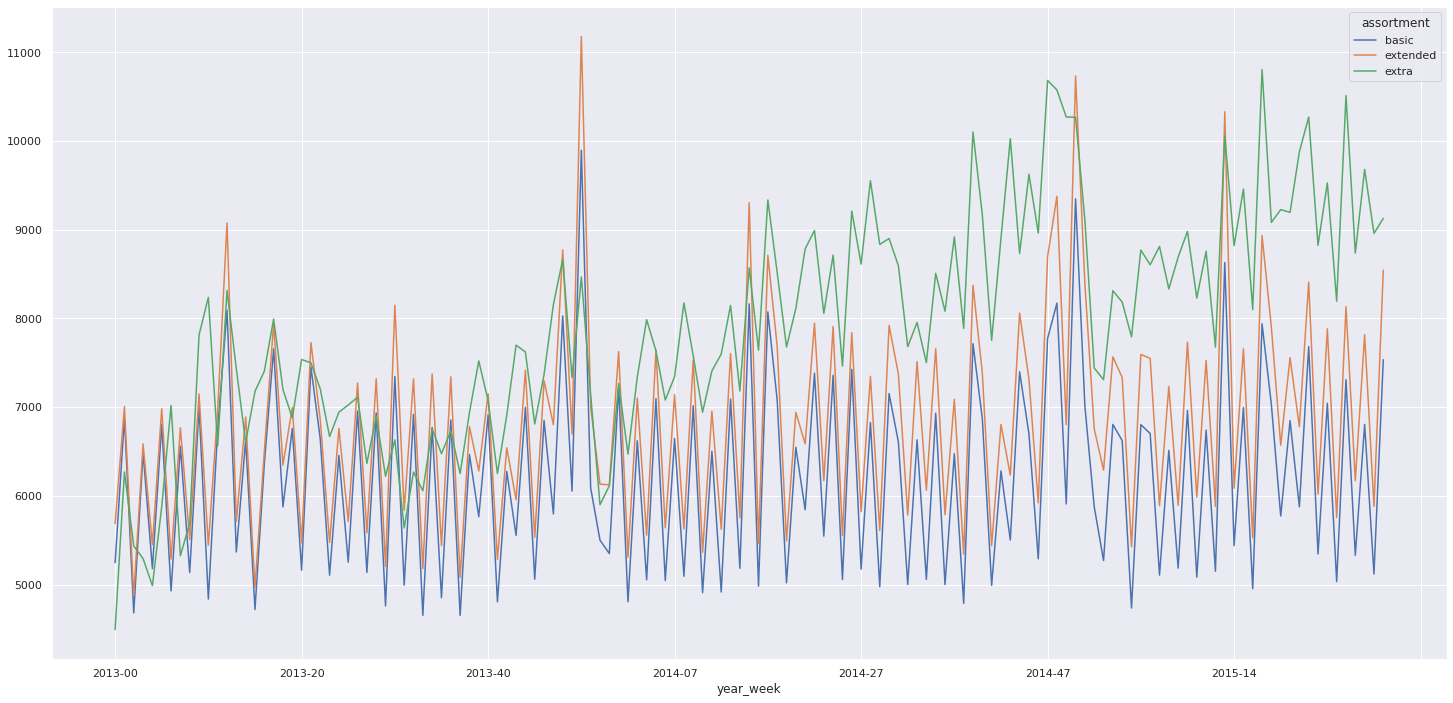

In [36]:

aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
sns.barplot(y='sales', x='assortment', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).median().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

####  H2. Lojas com competidores mais próximos deveriam vender menos.
**R: Falso**. Lojas com competidores mais próximos vendem mais.

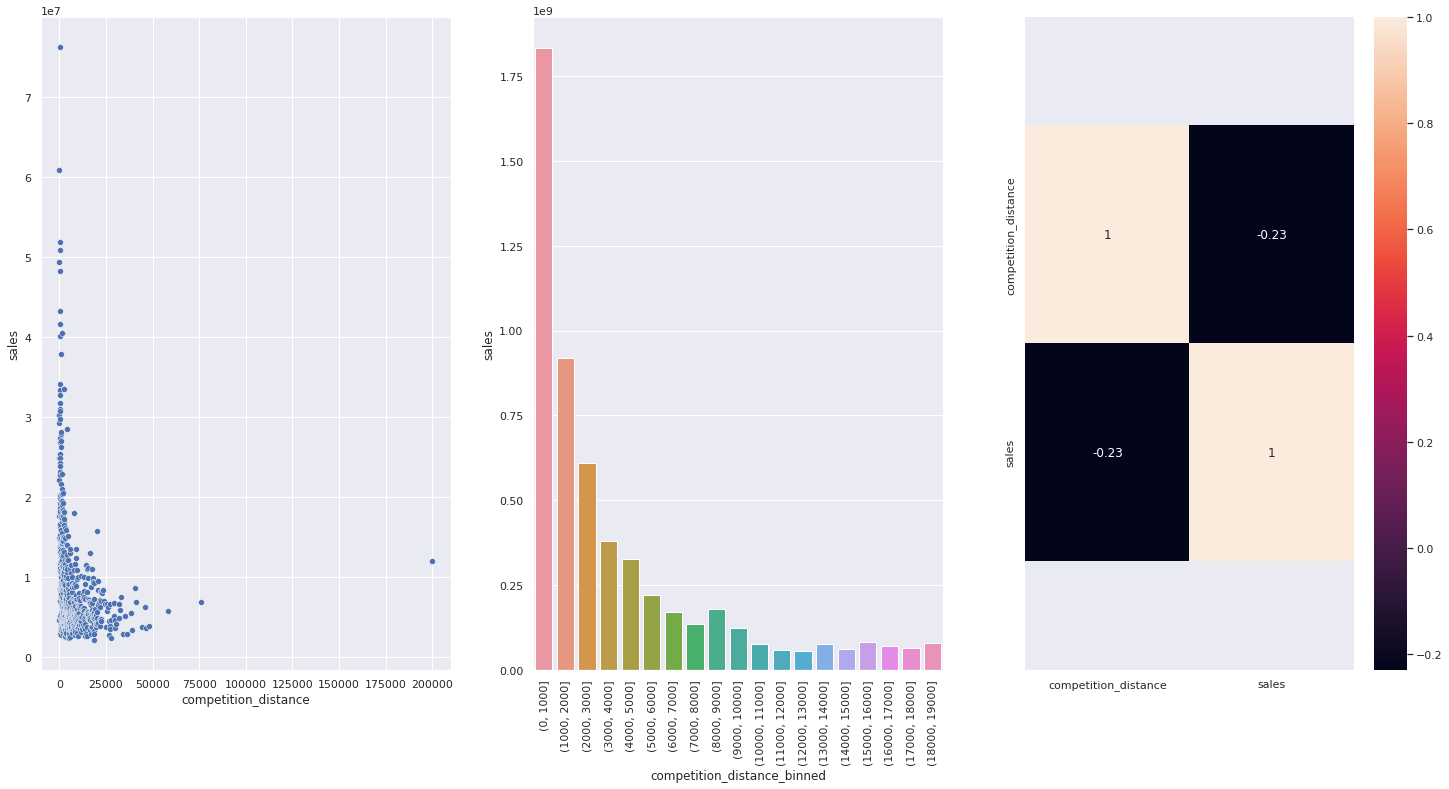

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### H3. Lojas com competidores à mais tempo deveriam vendem mais.

**R: Falso**. Lojas com concorrencia aberta a mais tempo vendem menos.

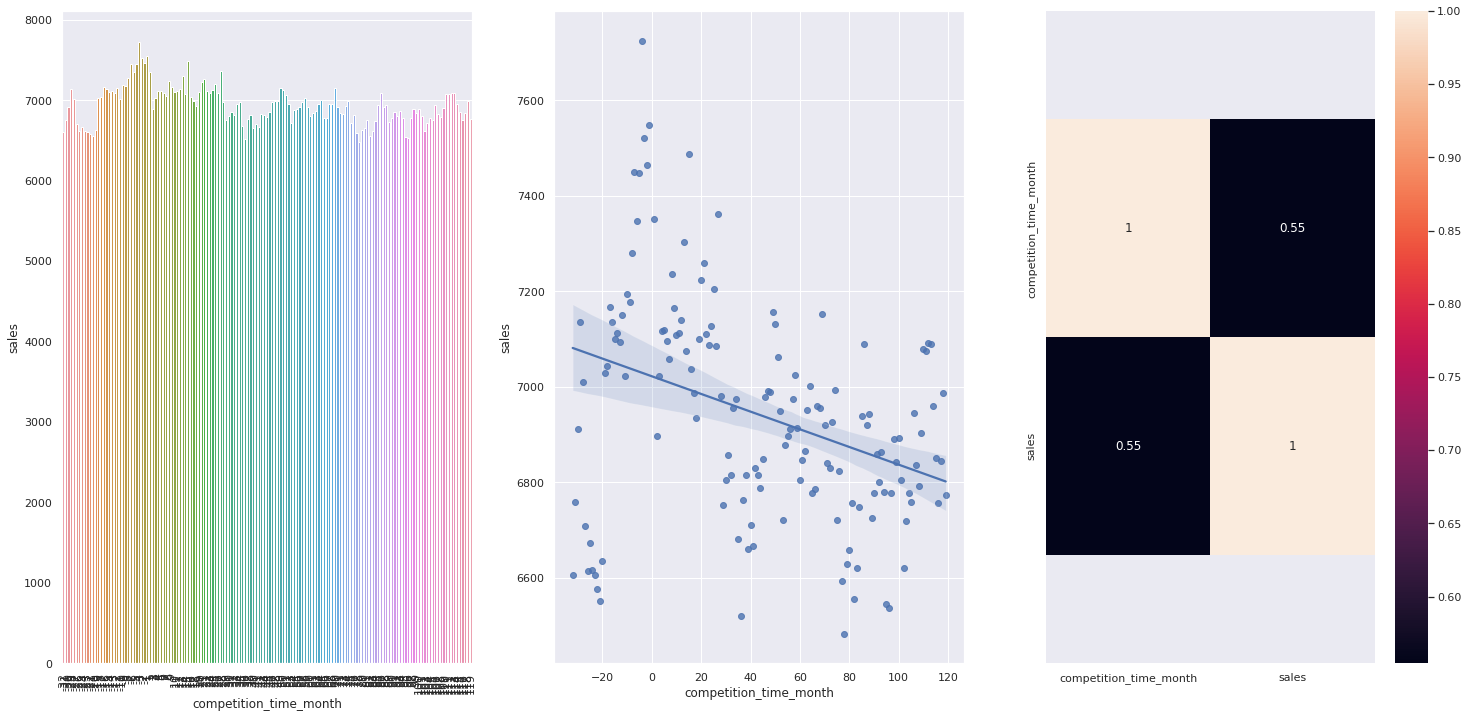

In [38]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );
plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**R: Falso.** Lojas em promoção por mais tempo não vendem mais.

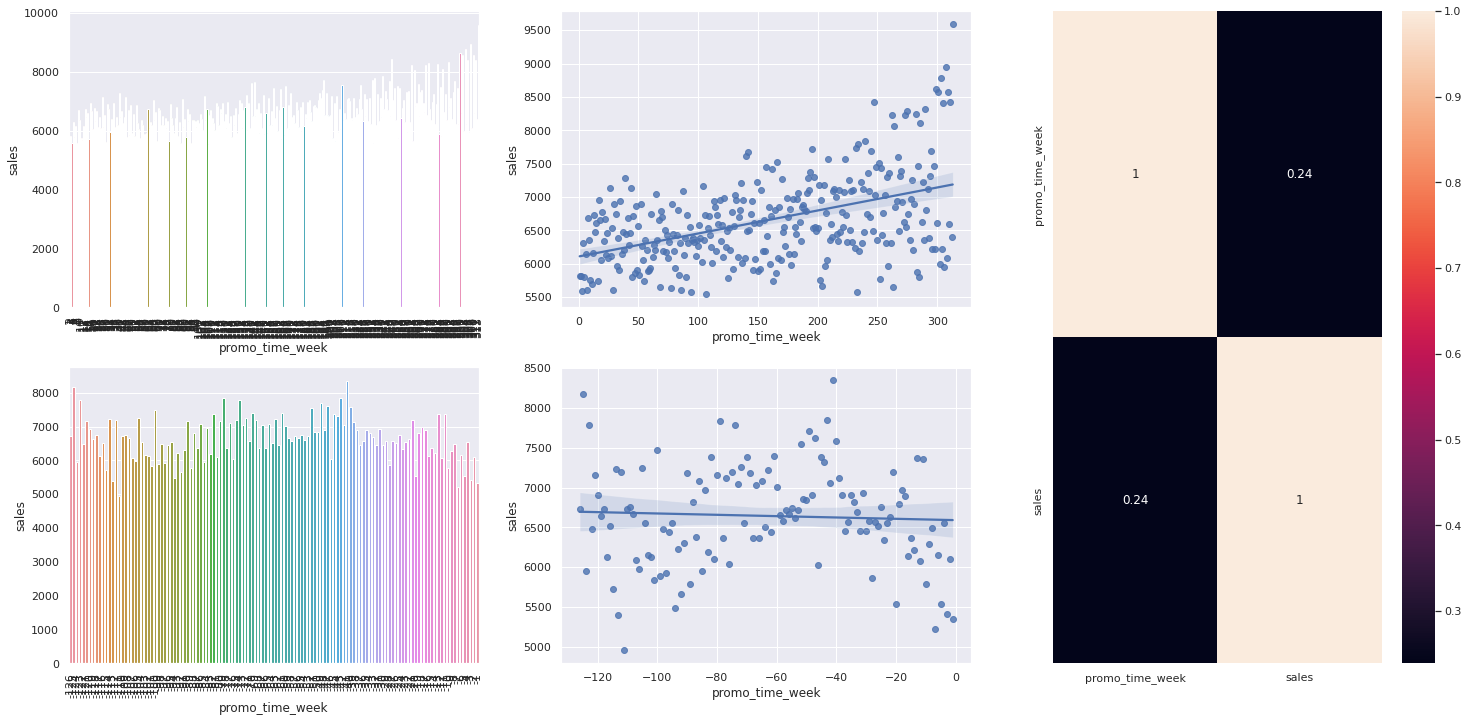

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### H5. Lojas com mais dias de promoção deveriam vender mais. 
Resposta no próximo ciclo

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**R: Falso.** Lojas com promoçoes consecutivas vendem menos 

In [40]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).mean().reset_index()

,promo,promo2,sales
0,0,0,6328.19
1,0,1,5529.57
2,1,0,8618.45
3,1,1,7836.67


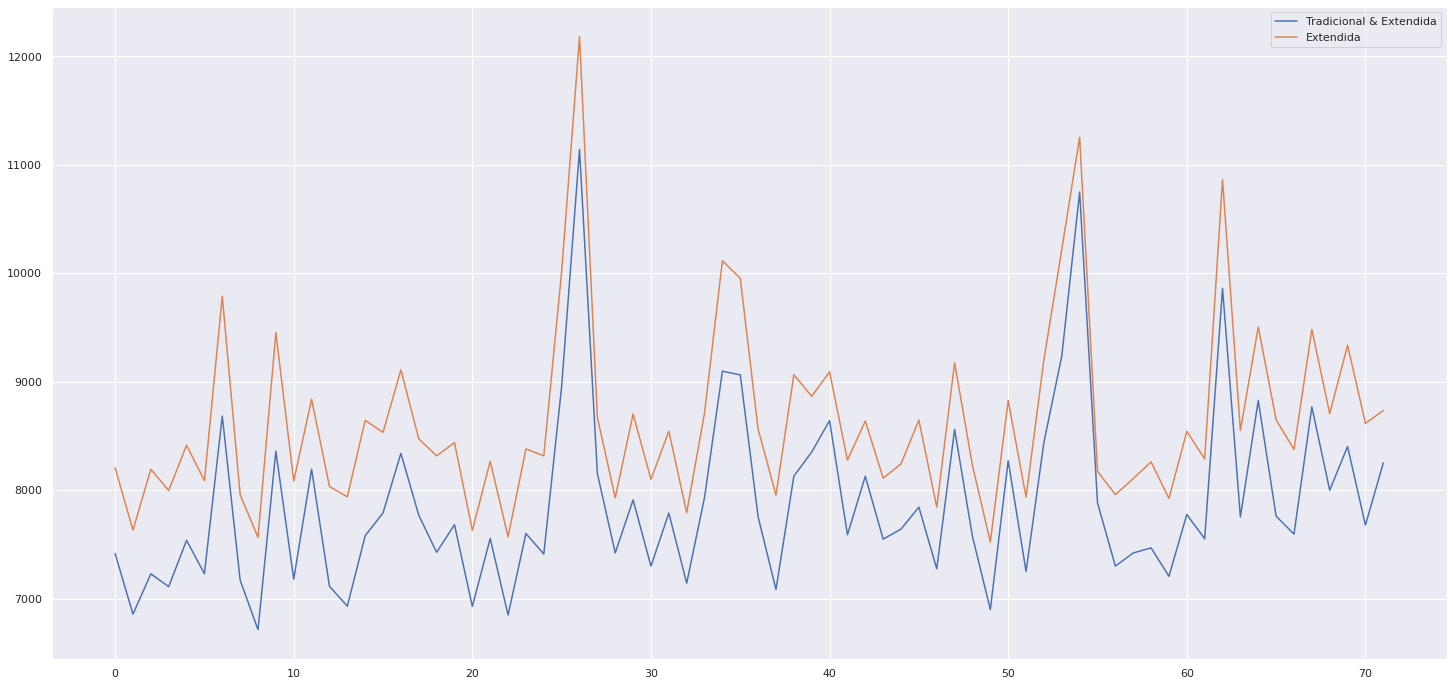

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).mean().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.

**R: Verdadeiro.** Lojas abertas durante o feriado de natal vendem mais.

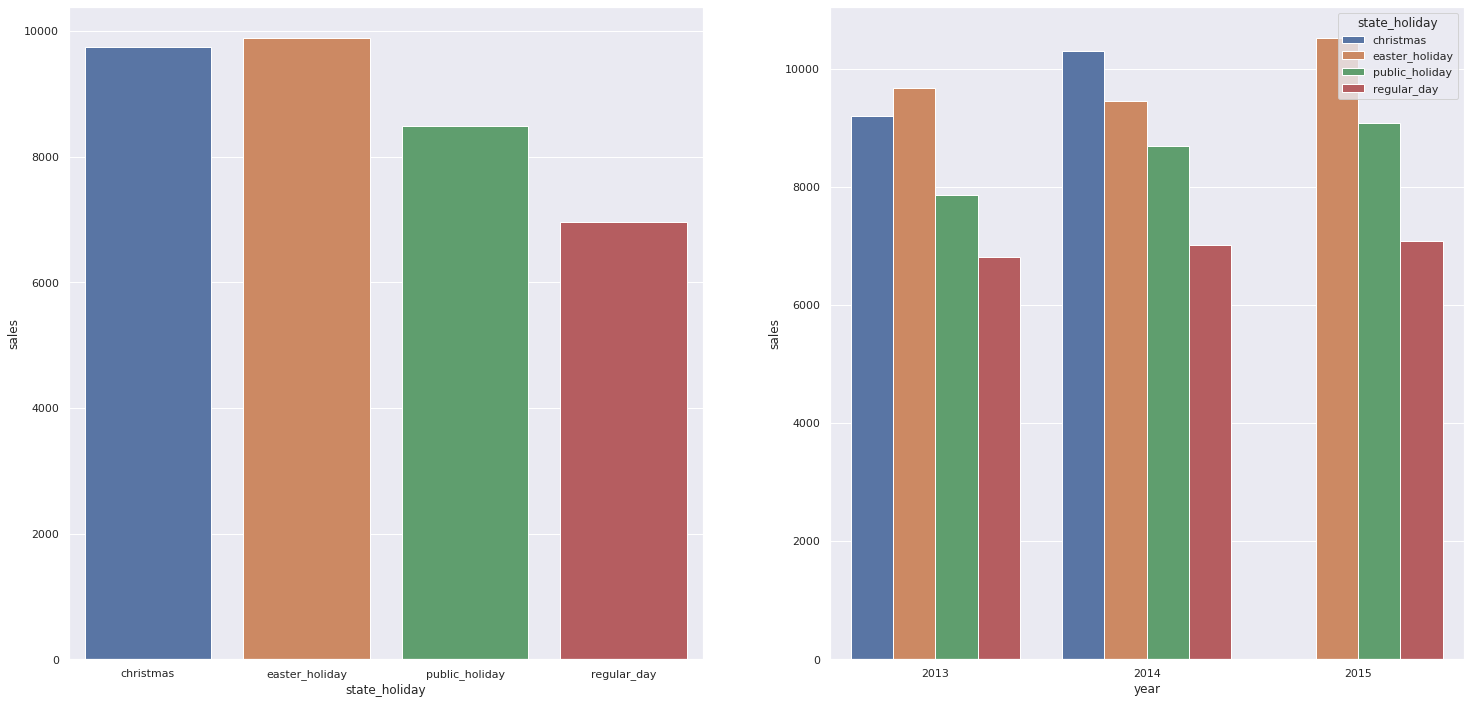

In [42]:
plt.subplot(1, 2, 1)
aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['state_holiday', 'year',]).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**R: Verdadeiro.** As vendas médias por loja aumentaram ao longo dos anos.

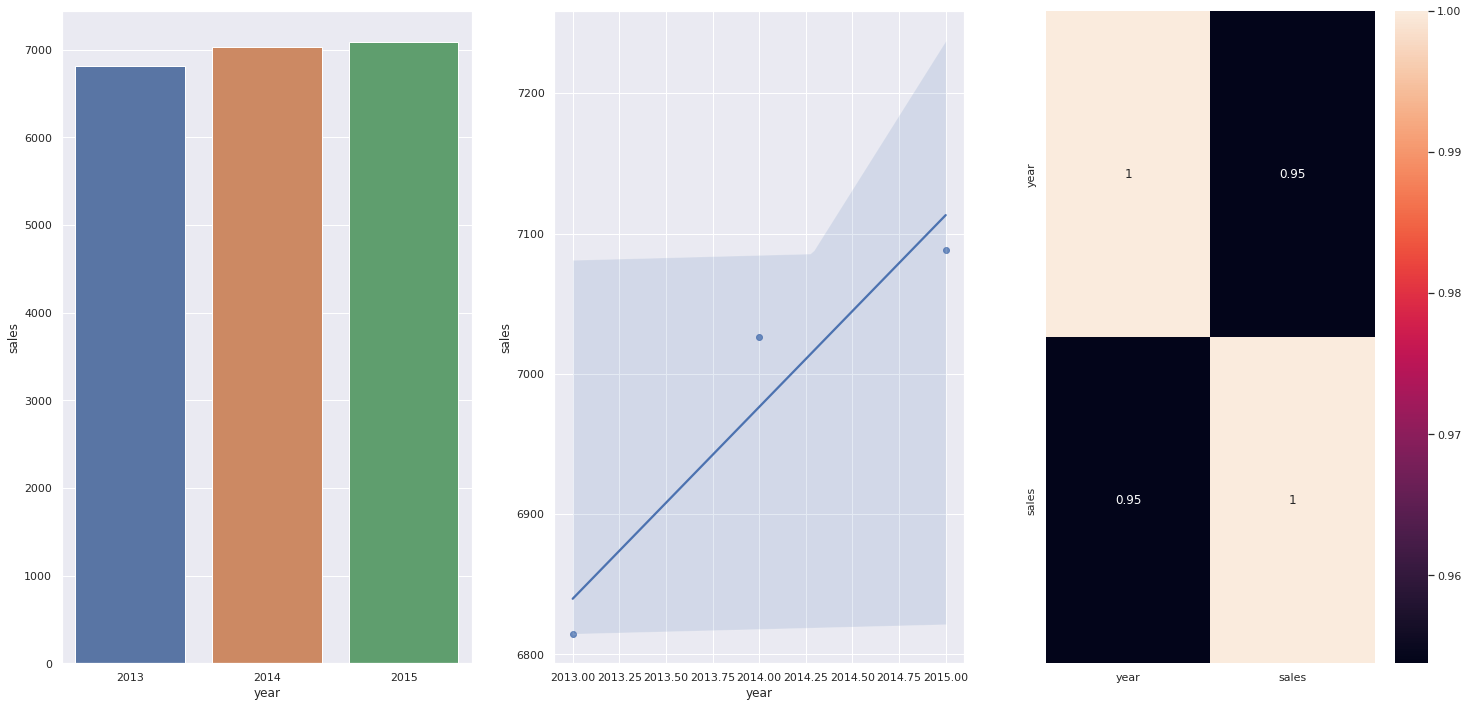

In [43]:
aux1 = df4[['sales', 'year']].groupby('year').mean().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**R: Falso.** A média de vendas do primeiro semestre é maior, mas a diferença é pouco significativa.

6856.815591549322
6788.359097928716


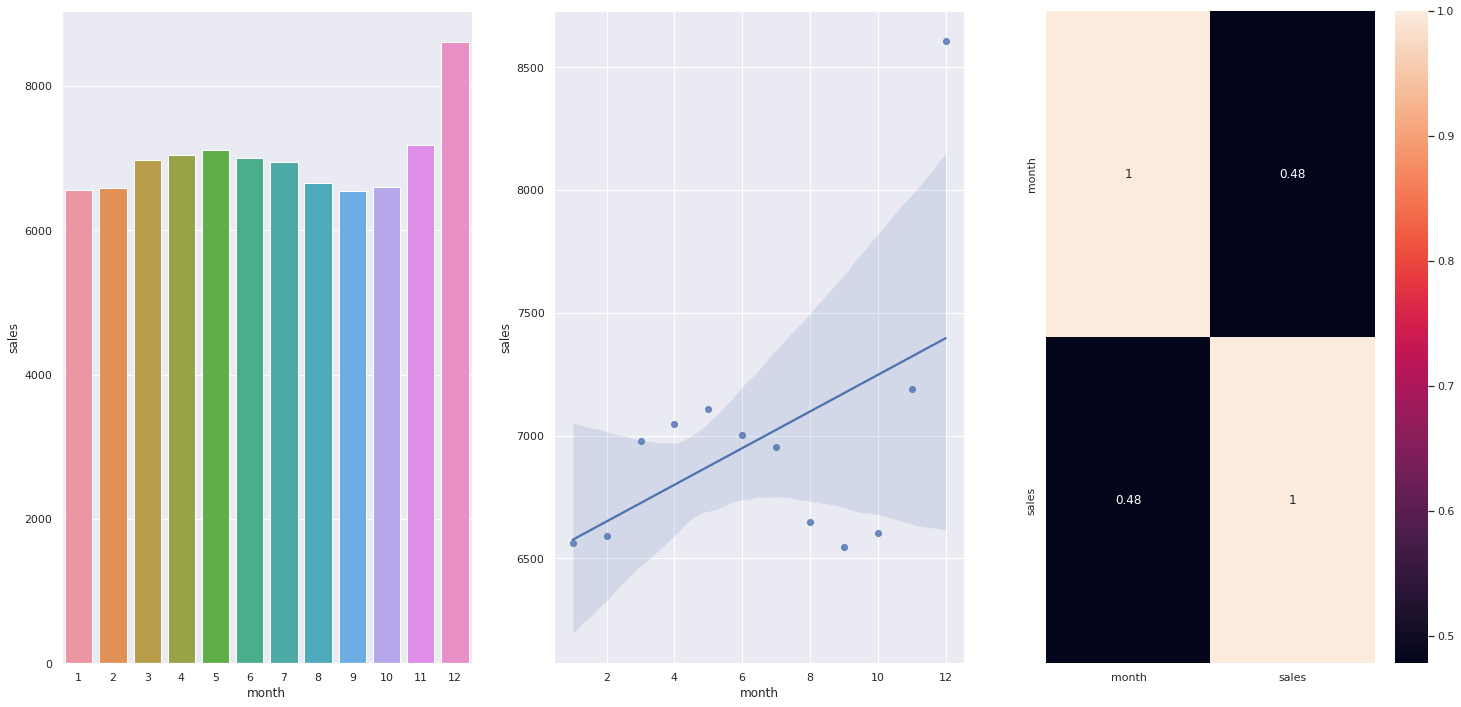

In [44]:
aux1 = df4[['sales', 'month']].groupby('month').mean().reset_index()
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

print(aux1['sales'][0:5].mean())
print(aux1['sales'][6:11].mean())

#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**R: Falso.** O volume médio por dia de vendas após o dia 10 é menor.

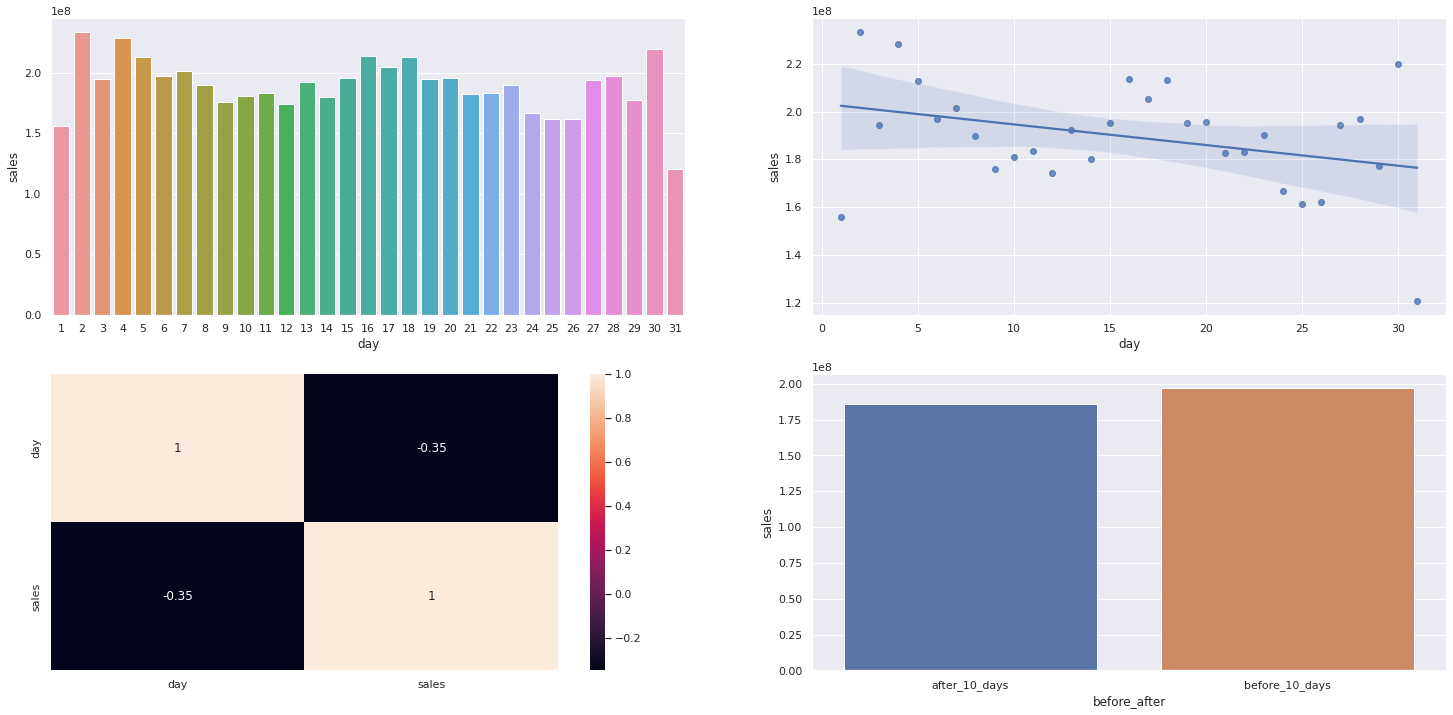

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).mean().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**R: Falso.** Lojas abertas aos finais de semana vendem mais aos domingos e segundas-feiras.

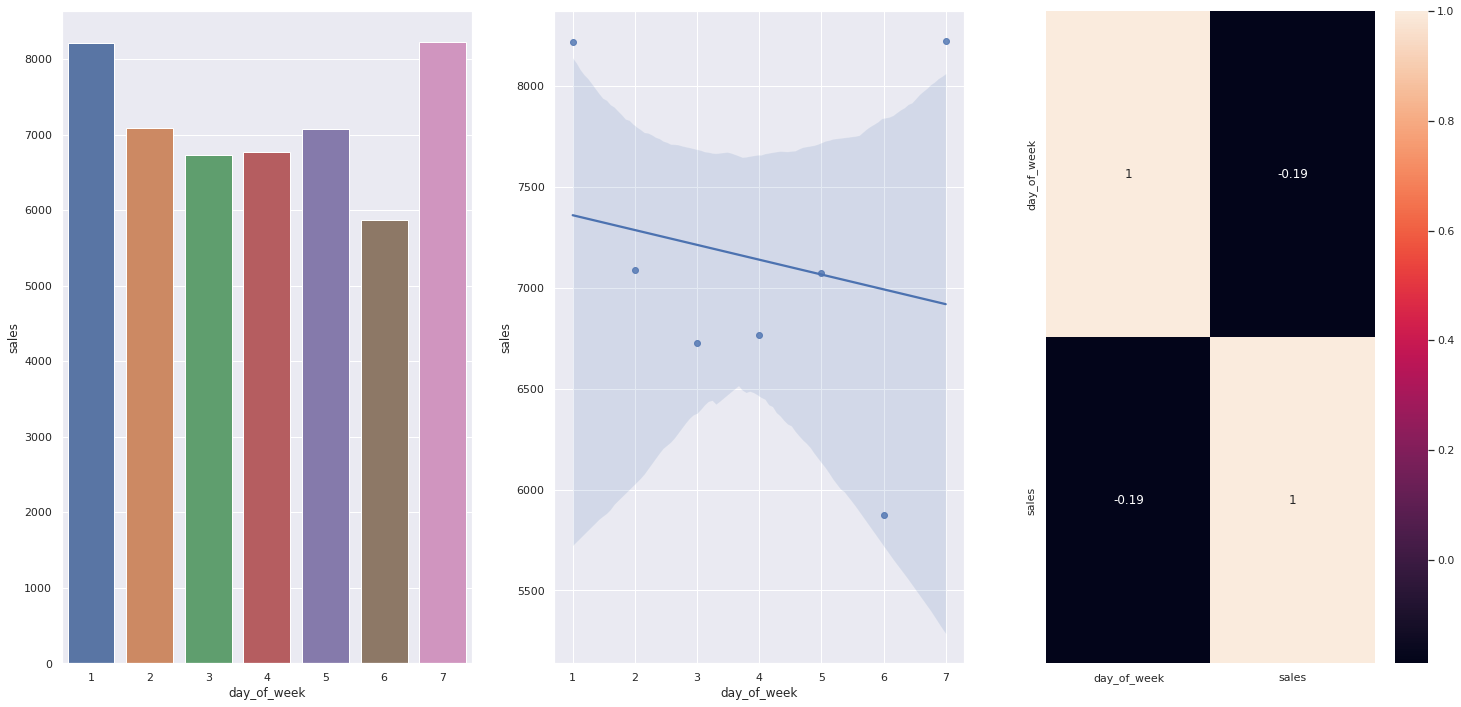

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).mean().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H12.** Lojas deveriam vender menos durante os feriados escolares.

**R: Verdadeiro.** As vendas durante os feriados escolares são sensivelmente maiores.

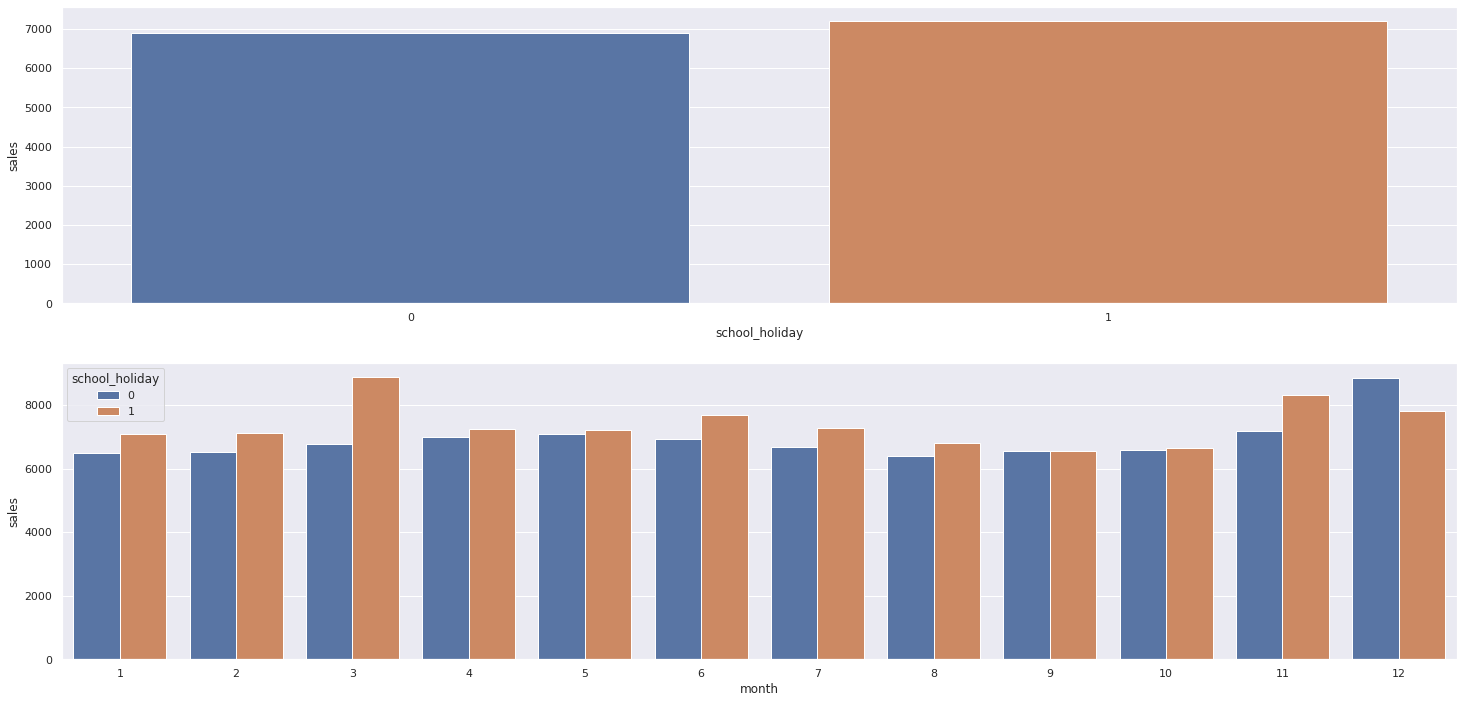

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1 Resumo das Hipóteses

In [48]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Verdadeira', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Verdadeira', 'Media'],
['H8', 'Verdadeira', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Verdadeira   Media
H8           Verdadeira   Alta
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1 Numerical Attributes

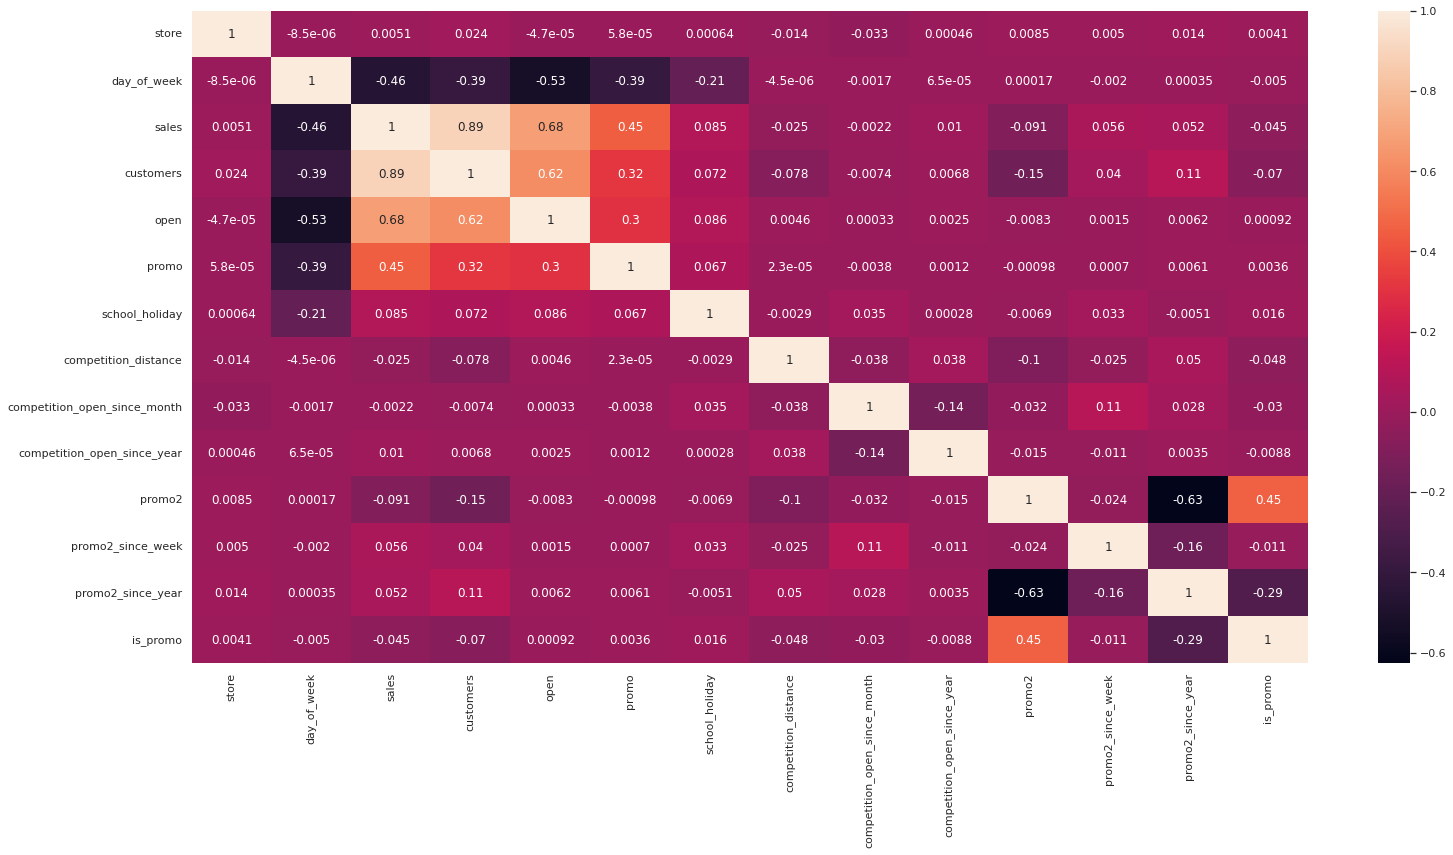

In [49]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True)

In [50]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

### 4.3.1 Categorical Attributes

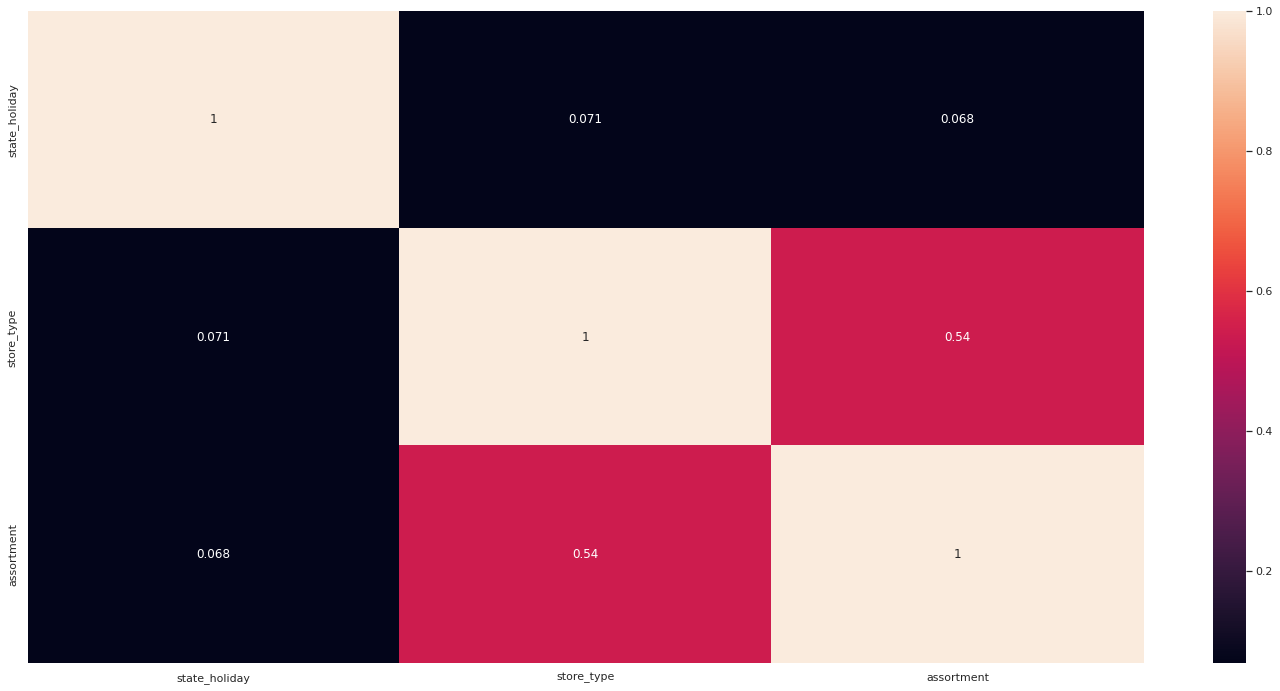

In [51]:
# only categorical data
a = df4.select_dtypes(include='object')

# calculate cramer v:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])


# Final dataset:
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]
             })
d = d.set_index(d.columns)

sns.heatmap( d, annot=True )

# 5.0. - PASSO 05 - DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalização

In [53]:
# none

## 5.2. Rescaling

In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance - robust scaler
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)


# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


## 5.3. Transformação

### 5.3.1. Encoding

In [55]:
# state_holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3 }

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [56]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [57]:
# day of week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin( x * ((2 * np.pi)/ 7)))
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos( x * ((2 * np.pi)/ 7)))

# month
df5['month_sin']= df5['month'].apply(lambda x: np.sin( x * ((2 * np.pi)/ 12)))
df5['month_cos']= df5['month'].apply(lambda x: np.cos( x * ((2 * np.pi)/ 12)))

# day
df5['day_sin']= df5['day'].apply(lambda x: np.sin( x * ((2 * np.pi)/ 31)))
df5['day_cos']= df5['day'].apply(lambda x: np.cos( x * ((2 * np.pi)/ 31)))


# week of year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin( x * ((2 * np.pi)/ 52)))
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos( x * ((2 * np.pi)/ 52)))

In [58]:
df5.sample(5).T

,270992,32214,47252,528771,415637
store,19,995,423,1047,528
day_of_week,1,5,5,6,2
date,2014-11-24 00:00:00,2015-07-03 00:00:00,2015-06-19 00:00:00,2014-03-15 00:00:00,2014-06-24 00:00:00
sales,9.24,9.33,9.46,7.90,8.97
promo,1,1,1,0,0
school_holiday,0,0,0,0,0
store_type,0,3,1,0,0
assortment,3,1,1,1,3
competition_distance,0.15,0.68,-0.17,0.23,2.95
competition_open_since_month,11,12,5,3,6


# 6.0. PASSO 06 - FEATURE SELECTION

In [59]:
df6 = df5.copy()

##  6.1. Split dataframe into training and test dataset

In [60]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [61]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


 ## 6.2. Boruta as Feature Selector

In [62]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


In [63]:
#cols_selected = boruta.support_.tolist()

# best features from boruta
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

# not selected from boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [64]:
#cols_selected_boruta

# Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
#       'competition_open_since_month', 'competition_open_since_year', 'promo2',
#       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
#       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'montht_cos',
#       'day_sin', 'day_cos', 'week_of_year_cos'],
#      dtype='object')

## 6.3. Manual Feature selection

In [65]:
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2',
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week', 
                        'day_of_week_sin', 
                        'day_of_week_cos', 
                        'month_sin',
                        'month_cos', 
                        'day_sin', 
                        'day_cos', 
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [66]:
x_train = X_train[cols_selected_boruta]

x_test = X_test[cols_selected_boruta]

x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [67]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performace
baseline_result = ml_error('Avarage Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.80,0.21,1835.14


## 7.2. Linear Regression Model

In [68]:
#x_train_lr = x_train.copy()
#x_train_lr.dtypes

#x_test_lr = x_test.drop(columns=['date'])
#x_test_lr.dtypes

In [70]:
# model
lr = LinearRegression().fit( x_train, Y_train )
# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.65,0.29,2671.33


### 7.2.1. Linear Regression Model - Cross Validation

In [80]:
model=LinearRegression()
lr_result_cv = cross_validation(x_training, 5, "Linear Regression", lr)

In [81]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22


## 7.3. Linear Regression Regularizaded Model - Lasso - Cross Validation

In [71]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, Y_train )

# prediction
yhat_lrr = lr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Lasso', np.expm1(Y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1867.65,0.29,2671.33


### 7.3.1. Linear Regression Regularizaded Model - Lasso

In [82]:
lrr_result_cv = cross_validation(x_training, 5, "Linear Regression Lasso", lrr)

In [83]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2115.78 +/- 341.38,0.29 +/- 0.01,3056.85 +/- 503.74


## 7.4. Random Forest Regressor

In [84]:
## model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, Y_train )

## prediction
#yhat_rf = rf.predict( x_test )

## performance
#rf_result = ml_error( 'Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf) )


In [73]:
#rf_result.to_csv('/content/drive/MyDrive/Data Scientist/ds-em-producao/data/rf_result.csv')

### 7.4.1. Random Forest Regressor - Cross Validation

In [85]:
rf_result_cv = cross_validation(x_training, 5, "Random Forest Regressor", rf, verbose=True)


Kfold number: 5.

Kfold number: 4.

Kfold number: 3.

Kfold number: 2.

Kfold number: 1.


In [86]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,861.81 +/- 251.25,0.12 +/- 0.03,1300.53 +/- 387.69


## 7.5. XGBoost Regressor

In [87]:
# model
model_xgb = xgb.XGBRegressor(objectve='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9
                             ).fit( x_train, Y_train )

# prediction
#yhat_xgb = model_xgb.predict( x_test )

# performance
#xgb_result = ml_error( 'XG Boost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb) )
#xgb_result

[00:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### 7.5.1. XGBoost Regressor - Cross Validation

In [88]:
xgb_result_cv = cross_validation(x_training, 5, "XGBoost Regressor", model_xgb, verbose=True)


Kfold number: 5.
[01:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Kfold number: 4.
[01:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Kfold number: 3.
[01:09:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Kfold number: 2.
[01:13:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Kfold number: 1.
[01:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [89]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1080.4 +/- 189.09,0.15 +/- 0.02,1560.7 +/- 273.31


## 7.6. Compare Model's Performace

### 7.6.1. Single Performace

In [90]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]).reset_index(drop=True)
#modelling_result.to_csv('/content/drive/MyDrive/Data Scientist/ds-em-producao/data/modelling_result.csv')

NameError: ignored

In [78]:
modelling_result

### 7.6.2. Real Performance - Cross Validation

In [92]:
 modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
 modelling_result_cv.to_csv('/content/drive/MyDrive/Data Scientist/ds-em-producao/data/modelling_result_cv.csv')
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.31 +/- 295.69,0.3 +/- 0.02,2951.88 +/- 468.22
0,Lasso,2115.78 +/- 341.38,0.29 +/- 0.01,3056.85 +/- 503.74
0,Random Forest,861.81 +/- 251.25,0.12 +/- 0.03,1300.53 +/- 387.69
0,XGBoost Regressor,1080.4 +/- 189.09,0.15 +/- 0.02,1560.7 +/- 273.31
